<h1>Data Loading</h1>

Connecting this notebook with Google drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing all the necessary dependencies.

In [1]:
# !apt-get install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/master.zip
# !pip install pyproj==1.9.6
# !pip install fasttext
# !python -m spacy download pt
# !pip install tensorflow_addons

Importing the required packages.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import regex as re
from datetime import datetime
from tqdm import tqdm
import pickle
import scipy
from mpl_toolkits.basemap import Basemap
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, log_loss
import fasttext.util
import warnings
from tensorflow_addons.metrics import F1Score
from sklearn.utils.extmath import randomized_svd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Embedding, LSTM, Flatten, Concatenate, Reshape, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from xgboost import XGBClassifier
from prettytable import PrettyTable
from keras.models import load_model
from sklearn.metrics import plot_confusion_matrix


warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")

Loading the data directly using Kaggle API.

In [4]:
from google.colab import files
from datetime import datetime
api_token = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=01744aeb8720e9e134ca49b5c7af94ca4f8c6ec9e19e4fb71ddbcf4d61f0e0c3
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-04-27 07:28:41           3759        369  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           2181        218  1.0              
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            463         21  1.0              
dhruvildave/wikibooks-dataset                               Wikibooks Dataset             

In [7]:
!kaggle datasets download -d olistbr/brazilian-ecommerce
!unzip '/content/brazilian-ecommerce.zip'

 70% 30.0M/42.7M [00:00<00:00, 54.5MB/s]
100% 42.7M/42.7M [00:00<00:00, 113MB/s] 
Archive:  /content/brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


Loading all the CSV files onto RAM.

In [8]:
customers_dataset = pd.read_csv('/content/olist_customers_dataset.csv')
geolocation_dataset = pd.read_csv('/content/olist_geolocation_dataset.csv')
order_items_dataset = pd.read_csv('/content/olist_order_items_dataset.csv')
order_payments_dataset = pd.read_csv('/content/olist_order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv('/content/olist_order_reviews_dataset.csv')
orders_dataset = pd.read_csv('/content/olist_orders_dataset.csv')
products_dataset = pd.read_csv('/content/olist_products_dataset.csv')
sellers_dataset = pd.read_csv('/content/olist_sellers_dataset.csv')
product_category_name_translation = pd.read_csv('/content/product_category_name_translation.csv')

Schematic diagram explaining the connectivity between these tables.

All the tables in the database are connected to each other using primary and freign keys. We shall join all the individual CSV files to create a large table. All these keys end with the suffix 'id' or 'prefix'.


<img src="https://i.imgur.com/HRhd2Y0.png" alt="Database connectivity" width="800" height="500">

<h1>Exploratory data analysis</h1>

Since this dataset is based on a Brazilian e-commerce company, the area of circulation is most probably Brazil and its neighbouring countries. This is why we shall take the plot of the South American continent and use the geographical data mentioned in the geolocation dataset to visually depict the geographical locations of the orders.

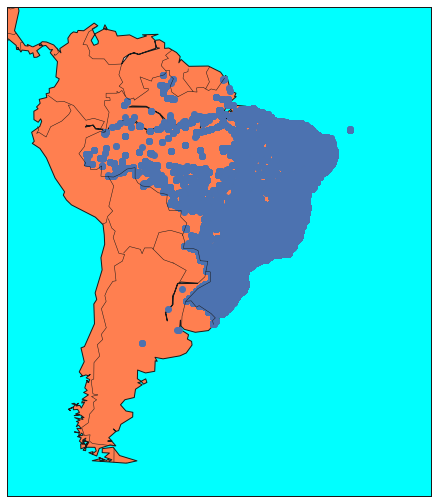

In [ ]:
latitudes = geolocation_dataset['geolocation_lat'].values
longitudes = geolocation_dataset['geolocation_lng'].values

plt.figure(figsize=(14,9))
m = Basemap(llcrnrlat=-60,llcrnrlon=-85,urcrnrlat=15,urcrnrlon=-20)
m.drawcoastlines()
m.fillcontinents(color='coral')
m.scatter(longitudes,latitudes, zorder=2)
m.drawmapboundary(fill_color='aqua')
m.drawcountries()

plt.show()

For further analysis, we won't be using the geolocation dataset. This is why it won't be added to the main dataframe.

In [9]:
order_items_products = pd.merge(order_items_dataset,products_dataset,on='product_id')
order_items_products_sellers = pd.merge(order_items_products,sellers_dataset,on='seller_id')
two_order_items_products_sellers = pd.merge(order_items_products_sellers,orders_dataset,on='order_id')
two_order_items_products_sellers_customer = pd.merge(two_order_items_products_sellers,customers_dataset,on='customer_id')
two_order_items_products_sellers_customer_reviews = pd.merge(two_order_items_products_sellers_customer,order_reviews_dataset,on='order_id')
final_dataframe = pd.merge(two_order_items_products_sellers_customer_reviews,order_payments_dataset,on='order_id')

We are given an extra csv file named 'product categry name translation'. This file contains the English translations of the original Portuguese text. We shall replace the original product category names with these translations.

In [10]:
mapping = dict(zip(product_category_name_translation['product_category_name'].tolist(),product_category_name_translation['product_category_name_english'].tolist()))
final_dataframe['product_category_name'] = final_dataframe['product_category_name'].map(mapping)

In [11]:
final_dataframe.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1,credit_card,2,72.19
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 00:00:00,2017-07-17 12:50:07,1,boleto,1,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05 00:00:00,2018-06-06 21:41:12,1,credit_card,2,83.23


There are a few columns in this table which may not be necessary.

In [12]:
print(final_dataframe.columns)
final_dataframe.shape

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')


(118315, 39)

Dropping all the duplicates which have the same Order ID, Customer ID, purchase timestamp, review message. This is becasue a customer cannot post the same review multiple times for the same product at the same instant of time.

In [13]:
final_dataframe = final_dataframe.drop_duplicates(subset=['order_id','order_purchase_timestamp','product_id','customer_unique_id','review_comment_message'])
final_dataframe.shape

(102683, 39)

All the ID values are unique. We are dropping these columns since they don't contribute much to understanding the data. We also cannot work with 

In [14]:
final_dataframe.drop(['order_id','product_id','seller_id','customer_unique_id'], axis=1, inplace=True)
final_dataframe.columns

Index(['order_item_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value'],
      dtype='object')

For datetime data, we cannot work with null values. Dropping those rows which contain null values is needed.

In [15]:
final_dataframe.dropna(subset=['shipping_limit_date','order_purchase_timestamp','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'], inplace=True)

We are parsing through some of the datetime columns and extracting the date information. The 'purchase delivery difference' gives us the number of days between the time of purchase and delivery. The 'estimated actual delivery difference' gives us the delay or the cut-down in the number of days actually required for the delivery.

In [16]:
intermediate_time = final_dataframe['order_delivered_customer_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date()) - final_dataframe['order_purchase_timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())
final_dataframe['purchase-delivery difference'] = intermediate_time.apply(lambda x:x.days)

intermediate_time = final_dataframe['order_estimated_delivery_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date()) - final_dataframe['order_delivered_customer_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())
final_dataframe['estimated-actual delivery difference'] = intermediate_time.apply(lambda x:x.days)

While moving onto the other types of columns, we shall find how many rows contains null values.

In [17]:
final_dataframe.isnull().sum()

order_item_id                               0
shipping_limit_date                         0
price                                       0
freight_value                               0
product_category_name                    1426
product_name_lenght                      1406
product_description_lenght               1406
product_photos_qty                       1406
product_weight_g                           16
product_length_cm                          16
product_height_cm                          16
product_width_cm                           16
seller_zip_code_prefix                      0
seller_city                                 0
seller_state                                0
customer_id                                 0
order_status                                0
order_purchase_timestamp                    0
order_approved_at                          14
order_delivered_carrier_date                0
order_delivered_customer_date               0
order_estimated_delivery_date     

After finding all the null values, we shall impute. For the categorical columns, we shall use the mode and for numerical columns we shall use the median for imputation. For revivew comments and title, we use the term 'indisponível' which is the Portuguese for unavailable.

In [18]:
final_dataframe['product_category_name'].fillna(value=final_dataframe['product_category_name'].mode()[0], inplace=True)
final_dataframe['product_name_lenght'].fillna(value=final_dataframe['product_name_lenght'].mode()[0], inplace=True)
final_dataframe['product_description_lenght'].fillna(value=final_dataframe['product_description_lenght'].median(), inplace=True)
final_dataframe['product_photos_qty'].fillna(value=final_dataframe['product_photos_qty'].mode()[0], inplace=True)
final_dataframe['product_weight_g'].fillna(value=final_dataframe['product_weight_g'].mode()[0], inplace=True)
final_dataframe['product_length_cm'].fillna(value=final_dataframe['product_length_cm'].mode()[0], inplace=True)
final_dataframe['product_height_cm'].fillna(value=final_dataframe['product_height_cm'].mode()[0], inplace=True)
final_dataframe['product_width_cm'].fillna(value=final_dataframe['product_width_cm'].mode()[0], inplace=True)
final_dataframe['review_comment_message'].fillna(value='indisponível', inplace=True)

It is possible to convert this problem into a multiclass classification task. For doing this, we shall convert all the review scores greater than 3 as part of the positive and the ones below 3 as part of the negative class. Reviews which have the value of 3 is considered to be part of the neutral class.

In [19]:
final_dataframe['review_score'] = final_dataframe['review_score'].apply(lambda x: 1 if x > 3 else 0)

On plotting the pie chart showing the review scores, we see that the positive class occupies 78.55% of the entire dataset; whereas the negative class only occupies 13.99%. The neutral class only occupies 8.39%. This means that the entire dataset is imbalanced. 

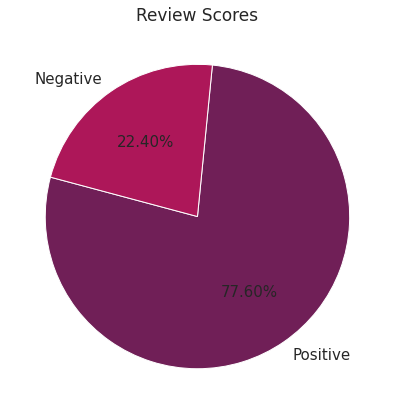

In [20]:
plt.figure(figsize=(7,7))
final_dataframe['review_score'].map({0:'Negative',1:'Positive'}).value_counts().plot.pie(autopct='%.2f%%', textprops={'fontsize':15}, startangle=165, colors=['#701f57','#ad1759','#f6b48f'])
plt.title('Review Scores', fontsize=17)
plt.ylabel('')
plt.show()

Some columns contain only numerical data. This means that finding the basic statistics of these columns is one thing which we can try. Notice that there is a significant difference between the mean and median values for the 'price' and 'product length description' columns. 

In [21]:
final_dataframe[['price','freight_value','product_name_lenght','product_description_lenght','product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm']].describe().round(3)

,price,freight_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,100442.000,100442.000,100442.000,100442.000,100442.000,100442.000,100442.000,100442.000
mean,123.698,20.067,49.048,783.493,2085.375,30.074,16.364,23.031
std,187.508,15.773,9.979,645.331,3739.584,16.064,13.268,11.729
min,0.850,0.000,5.000,4.000,0.000,7.000,2.000,6.000
25%,40.000,13.140,43.000,348.000,300.000,18.000,8.000,15.000
50%,78.000,16.320,52.000,602.000,700.000,25.000,13.000,20.000
75%,139.000,21.190,57.000,980.000,1800.000,38.000,20.000,30.000
max,6735.000,409.680,76.000,3992.000,40425.000,105.000,105.000,118.000


Let us create a new column called 'price category' This column is used to categorize the goods as expensive, cheap and affordable based on their price. We have used the first, second and third quartiles as the conditions for creating these categories.

In [22]:
final_dataframe['price_category'] = final_dataframe['price'].apply(lambda x:'expensive' if x>=139 else ('affordable' if x>=40 and x<139 else 'cheap'))

We are now finding the top 12 most popular product categories in terms of the frequency of purchase. THe category 'bed bath table' significantly more popular than most of the other categories. It is the only category whose sales have crossed 10000 units. The category in the 12th position - 'garden tools' only had around 3500 units sold.

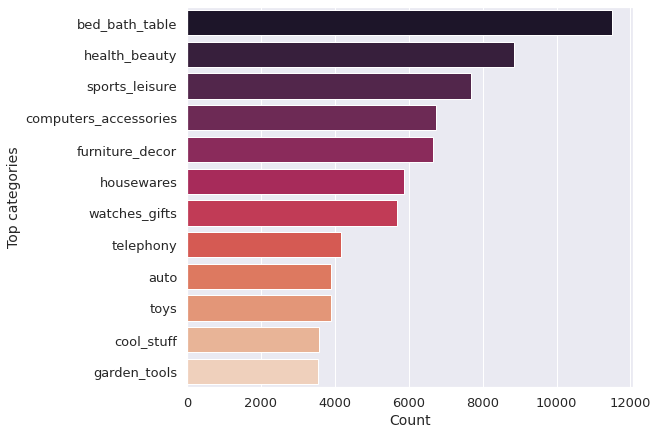

In [23]:
plt.figure(figsize=(8,7))
idx = final_dataframe['product_category_name'].value_counts()[:12].index
sns.countplot(y=final_dataframe['product_category_name'], order=idx, palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Top categories', fontsize=14)
plt.show()

Sao Paulo, also shortened to 'SP' is by leaps and bounds the state with the highest customer base for this firm. It might be dur to the fact that this company's headquarters is set up in Sao Paulo and more customers were informed about this website due to their heavy marketing strategy around that area. More than 40000 units were sold in Sao Paulo between 2016 and 2018.

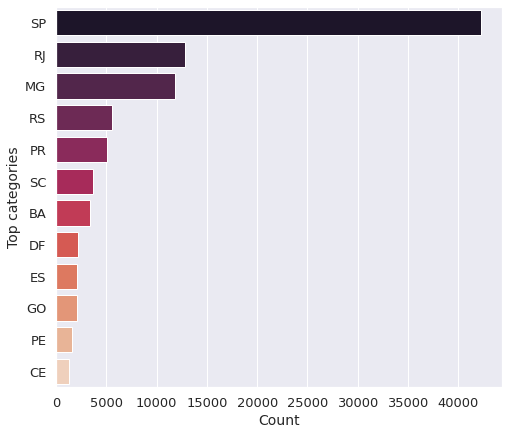

In [24]:
plt.figure(figsize=(8,7))
idx = final_dataframe['customer_state'].value_counts()[:12].index
sns.countplot(y=final_dataframe['customer_state'], order=idx, palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Top categories', fontsize=14)
plt.show()

When we check the pricing per product category, we can see that the average cost of a product is the highest for the items belonging to the 'computers' category. The average cost is around 1500 real. The second highest category has an average price of nearly half of the highest category.

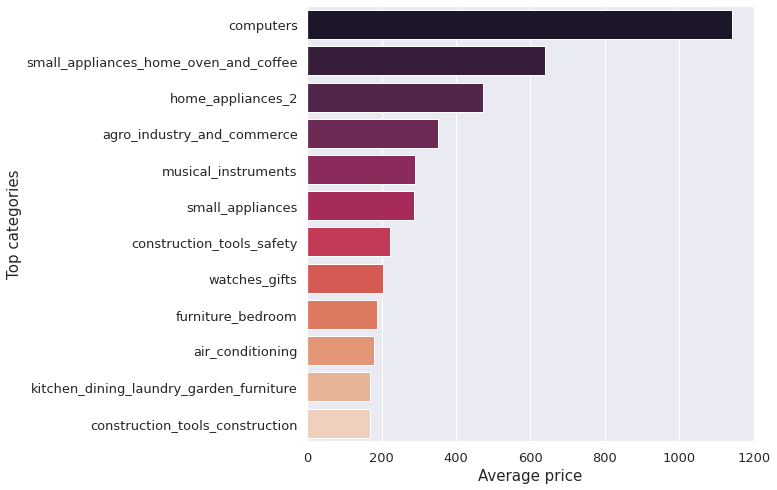

In [25]:
grp_cat_name = final_dataframe.groupby('product_category_name')
grp_dict = dict(grp_cat_name.mean()['price'].sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top categories', fontsize=15)
plt.show()

For this plot, we considered the overall average cost of an item. This means that it is the sum of the fright charges and the original cost of the item. We can see that the ordering of the plot hasn't changed. It's only that the average cost of each category that has increased.

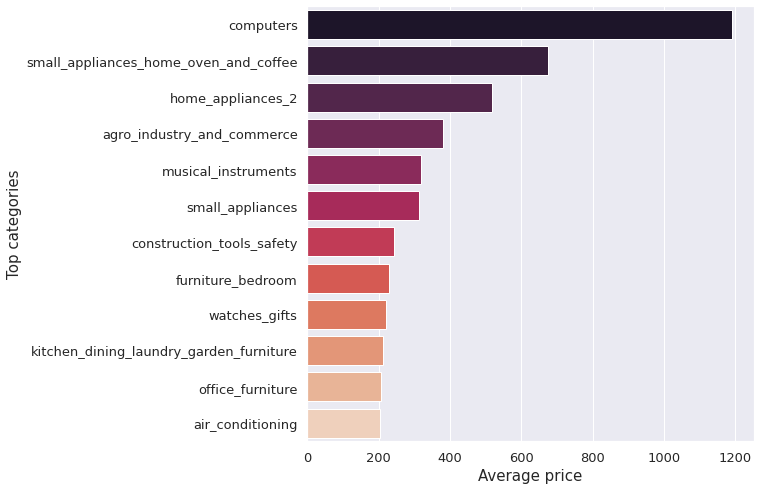

In [26]:
grp_dict = dict((grp_cat_name.mean()['price']+grp_cat_name.mean()['freight_value']).sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top categories', fontsize=15)
plt.show()

We are now finding the city which generates the highest revenue. The city named 'Pianco' generates the highest revenue.

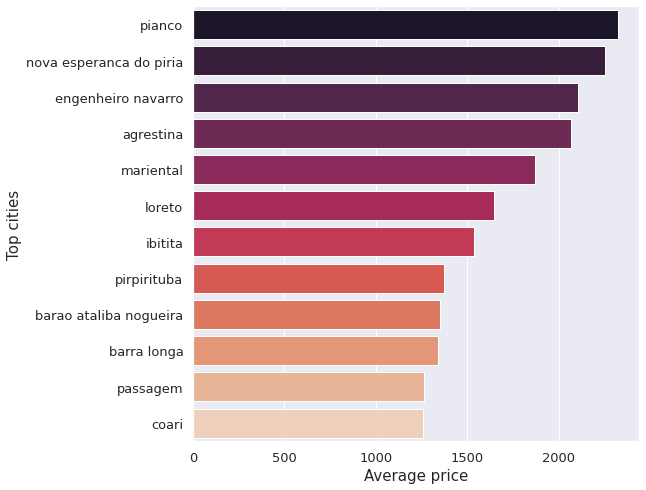

In [27]:
grp_state_name = final_dataframe.groupby('customer_city')
grp_dict = dict((grp_state_name.mean()['price']+grp_state_name.mean()['freight_value']).sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="rocket")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top cities', fontsize=15)
plt.show()

THere are only two statuses visible here. Only 6 orders have been cancelled till date.

In [28]:
final_dataframe['order_status'].value_counts()

delivered    100435
canceled          7
Name: order_status, dtype: int64

It doesn't make sense to analyze those products which have been cancelled. Thus, we shall delete them.

In [29]:
final_dataframe = final_dataframe[final_dataframe['order_status'] != 'canceled']

The below-given scatter plot takes the price on the x-axis and total time difference between delivery and purchase on the y-axis. It can be seen that as the time itaken for delivery increases, the chances to being dissatisfied with the product increases significantly. The increase in price of an item does not cause too much dissatisfaction if it is delivered on time.

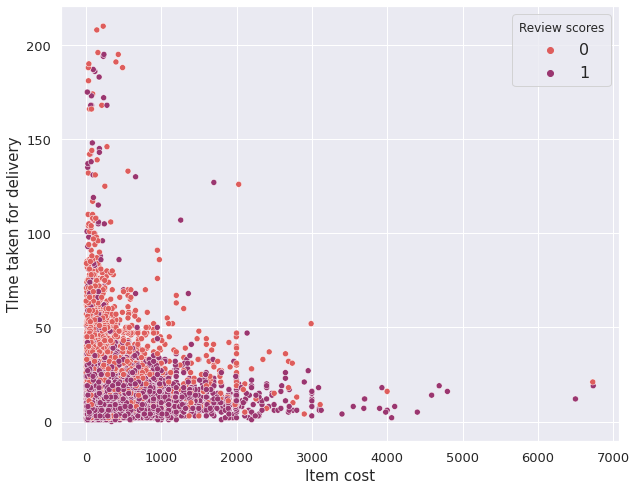

In [30]:
#Reference: https://stackoverflow.com/a/7125157

plt.figure(figsize=(10,8))
sns.scatterplot(x=final_dataframe['price'],y=final_dataframe['purchase-delivery difference'],hue=final_dataframe['review_score'],palette="flare")
plt.xlabel('Item cost', fontsize=15)
plt.ylabel('TIme taken for delivery', fontsize=15)
plt.legend(prop={'size':16}, title='Review scores')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [31]:
final_dataframe['purchase_delivery_diff_per_price'] = final_dataframe['purchase-delivery difference']/final_dataframe['price']

The scatter plot between the freight cost and item cost very much descriptive. But it can be said that even if the freight cost is high, customers were satisfied when the item cost is less.

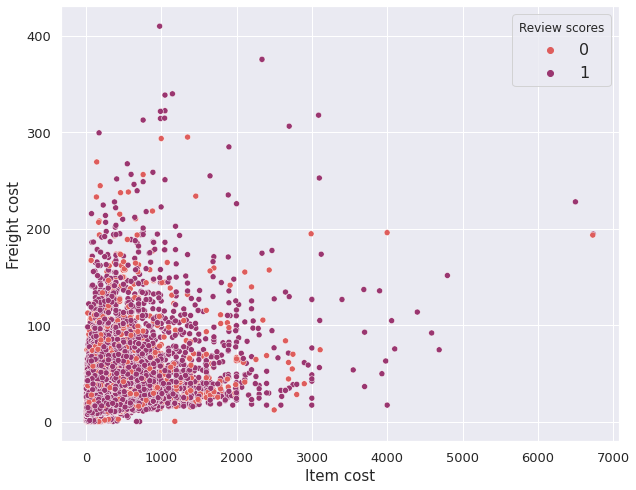

In [32]:
#Reference: https://stackoverflow.com/a/7125157

plt.figure(figsize=(10,8))
sns.scatterplot(x=final_dataframe['price'],y=final_dataframe['freight_value'],hue=final_dataframe['review_score'], palette='flare')
plt.xlabel('Item cost', fontsize=15)
plt.ylabel('Freight cost', fontsize=15)
plt.legend(prop={'size':16}, title='Review scores')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

Credit cards are the most popular mode of payment amongst the customers. They are much more popular than the other alternatives. The second in line, Boletos are a type of vouchers which can only be found only in Brazil. From this plot we could see that the bad reviews given to a product were most probably not because of a payment related issue.

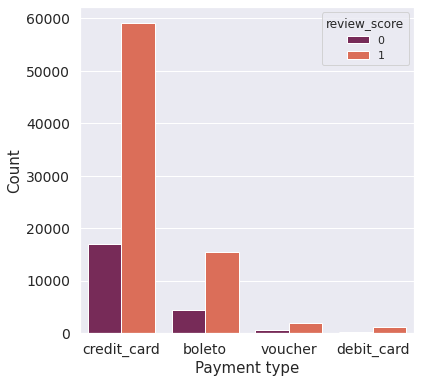

In [33]:
plt.figure(figsize=(6,6))
sns.countplot(data=final_dataframe,x='payment_type', hue='review_score', palette='rocket')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Payment type', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

Now it's time to drop all the columns which aren't necessary for the machine learning task. All the datetime columns should be removed.

In [34]:
final_dataframe.drop(['shipping_limit_date','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','customer_id'], axis=1, inplace=True)

We are creating a new variable called 'labels' which contain the edited class polarity. This column should be removed from the original table.

In [35]:
labels = final_dataframe['review_score']
final_dataframe.drop('review_score', axis=1, inplace=True)

The column 'review availability' checks whether the review for a particular product is available or not.

In [36]:
final_dataframe['review_availability'] = final_dataframe['review_comment_message'].apply(lambda x: 1 if x != 'indisponível' else 0)

For machine learning, we need to define a train set for training the data and a test set for predicting. Both these sets contain both the classes in equal proportion.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(final_dataframe, labels, stratify=labels, test_size=0.2, random_state=0)

<h1>Feature engineering</h1>

Creating a function which will encode the categorical features using response coding. This is the technique of representing the probability of a value to belong to any of the given classes.

In [38]:
#Code copied from my submission of the course assignment

def train_response(frame):
  f1 = frame[frame.iloc[:,1] == 0]
  f2 = frame[frame.iloc[:,1] == 1]
  global dict_frame, dict_f1, dict_f2
  dict_frame = dict(frame.iloc[:,0].value_counts())
  dict_f1 = dict(f1.iloc[:,0].value_counts())
  dict_f2 = dict(f2.iloc[:,0].value_counts())
  state_0, state_1 = [],[],
  for i in range(len(frame)):
    if frame.iloc[:,1][i] == 0:
      state_0.append(dict_f1.get(frame.iloc[:,0][i],0)/dict_frame[frame.iloc[:,0][i]])
      state_1.append(float(1-state_0[-1]))
    else:
      state_1.append(dict_f2.get(frame.iloc[:,0][i],0)/dict_frame[frame.iloc[:,0][i]])
      state_0.append(float(1-state_1[-1])) 
  df3 = pd.DataFrame({'State_0':state_0, 'State_1':state_1})
  return df3.to_numpy()

def test_response(test):
  t_state_0, t_state_1 = [],[]
  for i in range(len(test)):
    if dict_frame.get(test[i]):
      t_state_0.append(dict_f1.get(test[i],0)/dict_frame.get(test[i]))
      t_state_1.append(dict_f2.get(test[i],0)/dict_frame.get(test[i]))
    else:
      t_state_0.append(0.5)
      t_state_1.append(0.5)
  df4 = pd.DataFrame({'State_0':t_state_0, 'State_1':t_state_1})
  return df4.to_numpy()  

We shall encode the categorical features which contain fewer categories using one hot encoding and encode them using response coding if there are too many categories. There is no need to encode the numerical features. We won't be using one hot encoding when there are too many categories because it would add too many extra dimnesions and in turn lead to curse of dimensionality. Also note that we will be disregarding many features because they don't seem to be useful for the machine learning task.

In [40]:
X_train_resp_prod_cat = train_response(pd.concat([X_train['product_category_name'], y_train], axis=1).reset_index(drop=True))
X_test_resp_prod_cat = test_response(X_test['product_category_name'].values)

In [39]:
ohe_order_item = OneHotEncoder()
ohe_order_item.fit(X_train['order_item_id'].values.reshape(-1,1))
X_train_order_item = ohe_order_item.transform(X_train['order_item_id'].values.reshape(-1,1)).toarray()
X_test_order_item = ohe_order_item.transform(X_test['order_item_id'].values.reshape(-1,1)).toarray()

In [48]:
X_train_resp_payment_seq = train_response(pd.concat([X_train['payment_sequential'], y_train], axis=1).reset_index(drop=True))
X_test_resp_payment_seq = test_response(X_test['payment_sequential'].values)

In [49]:
ohe_payment_type = OneHotEncoder()
ohe_payment_type.fit(X_train['payment_type'].values.reshape(-1,1))
X_train_payment_type = ohe_payment_type.transform(X_train['payment_type'].values.reshape(-1,1)).toarray()
X_test_payment_type = ohe_payment_type.transform(X_test['payment_type'].values.reshape(-1,1)).toarray()

In [50]:
enc_price = OrdinalEncoder()
enc_price.fit(X_train['price_category'].values.reshape(-1,1))
enc_price.categories_ = [np.array([ 'cheap', 'affordable', 'expensive'], dtype=object)]
X_train_cat_price = enc_price.transform(X_train['price_category'].values.reshape(-1,1))
X_test_cat_price = enc_price.transform(X_test['price_category'].values.reshape(-1,1))

Since the 'review comment message' column contain text, we shall be converting it into 300-dimensional sentence embeddings.

In [52]:
ft = fasttext.load_model('/content/drive/MyDrive/Olist/cc.pt.300.bin')

In [53]:
embedding_matrix = np.zeros((len(ft.words), 300))
for i in tqdm(range(len(ft.words)), position=0, leave=True):
  embedding_matrix[i] = ft.get_word_vector(ft.words[i])

embedding_matrix.shape

100%|██████████| 2000000/2000000 [00:26<00:00, 75310.95it/s]


(2000000, 300)

Before vectorizing the text, we shall first clean it using different preprocessing techniques.

In [54]:
#Code copied from Applied AI reference

#References:
#https://stackoverflow.com/a/47218282
#https://stackoverflow.com/a/52057778
#https://stackoverflow.com/a/11332580
#https://stackoverflow.com/a/9532388

sp = spacy.load('pt')
all_stopwords = sp.Defaults.stop_words

def process_texts(texts): 

    processed_text = []
    dates = '^([0]?[1-9]|[1|2][0-9]|[3][0|1])[./-]([0]?[1-9]|[1][0-2])[./-]([0-9]{4}|[0-9]{2})$'
    
    for text in texts:
        text = re.sub(r'\r\n|\r|\n', ' ', text) 
        text = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', text) 
        text = re.sub(dates, ' ', text) 
        text = re.sub('[ \t]+$', '', text)
        text = re.sub('\W', ' ', text)
        text = re.sub('[0-9]+', ' ', text)
        text = re.sub('\s+', ' ', text)
        text = ' '.join(e for e in text.split() if e.lower() not in all_stopwords) 
        processed_text.append(text.lower().strip())
        
    return processed_text

In [55]:
X_train_comment_preprocess = process_texts(X_train['review_comment_message'])
X_test_comment_preprocess = process_texts(X_test['review_comment_message'])

X_train['embedded_review_comment_message'] = list(map(ft.get_word_vector,X_train_comment_preprocess))
X_test['embedded_review_comment_message'] = list(map(ft.get_word_vector,X_test_comment_preprocess))

It is important to standardize the numerical columns. We shall be doing that only. 

In [57]:
strn = StandardScaler()
strn.fit(X_train[['price','freight_value','product_photos_qty','product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'payment_value','purchase-delivery difference','estimated-actual delivery difference','purchase_delivery_diff_per_price']])
X_train_strn = strn.transform(X_train[['price','freight_value','product_photos_qty','product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'payment_value','purchase-delivery difference','estimated-actual delivery difference','purchase_delivery_diff_per_price']])
X_test_strn = strn.transform(X_test[['price','freight_value','product_photos_qty','product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'payment_value','purchase-delivery difference','estimated-actual delivery difference','purchase_delivery_diff_per_price']])

Let us concatenate all the features which are necessary for the machine learning task.

In [58]:
X_train_final = np.concatenate((X_train_strn,X_train_resp_prod_cat,X_train_order_item,
       X_train_resp_payment_seq,X_train_payment_type,X_train_cat_price,X_train['review_availability'].values.reshape(-1,1),
       np.vstack(X_train['embedded_review_comment_message'].values)), axis=1)

X_test_final = np.concatenate((X_test_strn,X_test_resp_prod_cat, X_test_order_item,
       X_test_resp_payment_seq,X_test_payment_type,X_test_cat_price,X_test['review_availability'].values.reshape(-1,1),
       np.vstack(X_test['embedded_review_comment_message'].values)), axis=1)

In [59]:
print(X_train_final.shape)
print(X_test_final.shape)

(80348, 332)
(20087, 332)


There are a total of 332 features in both our sets. We shall try to reduce this dimensionality using two techniques. One is by finding the hard threshold using singular value decomposition and the other is by using autoencoders.

<h1>Machine learning</h1>

In [ ]:
X_final_sparse = scipy.sparse.csr_matrix(np.vstack((X_train_final,X_test_final)))

In [ ]:
#Reference: http://www.pyrunner.com/weblog/2016/08/01/optimal-svht/

X_final_sparse = scipy.sparse.csr_matrix(np.vstack((X_train_final,X_test_final)))
U, sigma, VT = randomized_svd(X_final_sparse, n_components=min(X_final_sparse.shape[0],X_final_sparse.shape[1])-1,n_iter=5,random_state=45)
beta = min(X_final_sparse.shape) / max(X_final_sparse.shape)
omega_approx = 0.56*beta**3 - 0.95*beta**2 + 1.82*beta + 1.43
tau = np.median(sigma)*omega_approx
k = np.max(np.where(sigma>tau))+1

In [ ]:
X_final_truncated = (U[:,:k]*sigma[:k])
print(X_final_truncated.shape)

X_train_final_truncated = X_final_truncated[:X_train_final.shape[0],:]
X_test_final_truncated = X_final_truncated[X_train_final.shape[0]:,:]

(100435, 116)

There are 116 features which preserve most of the variance of our data.

In [ ]:
X_train_final_truncated = X_final_truncated[:X_train_final.shape[0],:]
X_test_final_truncated = X_final_truncated[X_train_final.shape[0]:,:]

We shall now design autoencoders for dimensionality reduction purposes. Note that the bottleneck layer has the dimensionality of 116.

In [ ]:
#Reference: https://machinelearningmastery.com/autoencoder-for-classification/

input_data = Input(shape=X_train_final.shape[1])
hidden_1 = Dense(512,activation='relu')(input_data)
batch_1 = BatchNormalization()(hidden_1)
hidden_2 = Dense(256,activation='relu')(batch_1)
batch_2 = BatchNormalization()(hidden_2)
bottle_neck = Dense(116,activation='relu')(batch_2)
batch_3 = BatchNormalization()(bottle_neck)
hidden_3 = Dense(256,activation='relu')(batch_3)
batch_4 = BatchNormalization()(hidden_3)
hidden_4 = Dense(512,activation='relu')(batch_4)
output_data = Dense(X_train_final.shape[1],activation='linear')(hidden_4)

In [ ]:
model = Model(inputs=input_data, outputs=output_data)
opt = Adam(learning_rate=0.0001)
path = '/content/drive/MyDrive/Olist/checkpoint'
model_check = ModelCheckpoint(filepath=path,monitor='val_loss',save_best_only=True,save_weights_only=True)
model.compile(optimizer=opt, loss='mse')
history = model.fit(X_train_final, X_train_final, epochs=15, batch_size=32, validation_data=(X_test_final,X_test_final))

Epoch 1/15
2511/2511 [==============================] - 23s 8ms/step - loss: 0.0663 - val_loss: 0.0080
Epoch 2/15
2511/2511 [==============================] - 23s 9ms/step - loss: 0.0083 - val_loss: 0.0036
Epoch 3/15
2511/2511 [==============================] - 24s 9ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 4/15
2511/2511 [==============================] - 25s 10ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 5/15
2511/2511 [==============================] - 26s 10ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 6/15
2511/2511 [==============================] - 23s 9ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 7/15
2511/2511 [==============================] - 26s 10ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/15
2511/2511 [==============================] - 28s 11ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 9/15
2511/2511 [==============================] - 27s 11ms/step - loss: 0.0018 - val_loss: 9.5391e-04
Epoch 10/15
2511/2511 [==============================] - 26s 10m

Plotting the training and test loss gives us a visual description of our training.

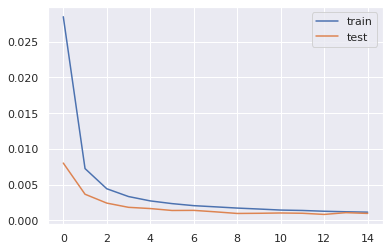

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
encoder = Model(inputs=input_data, outputs=bottle_neck)
X_train_encode = encoder.predict(X_train_final)
X_test_encode = encoder.predict(X_test_final)

We shall be using dividing the training into two sections. One section is for the dataset created using SVD and the other is the one created using autoencoders.

In [ ]:
def conf_plot(obj,X_train,y_train,X_test,y_test):
  fig, ax = plt.subplots(1,2, figsize=(8,4))
  plot_confusion_matrix(obj,X_train,y_train, ax=ax[0], values_format='d')
  ax[0].grid(False)
  ax[0].set_title('Train',fontsize=15)
  plot_confusion_matrix(obj,X_test,y_test, ax=ax[1], values_format='d')
  ax[1].set_title('Test',fontsize=15)
  ax[1].grid(False)
  plt.tight_layout()

<h1>Hard threshold SVD</h1>

For hyperparameter tuning, we shall be using the cross validation set which is part of the train set.

In [ ]:
X_train_final_new, X_cv_final, y_train_new, y_cv = train_test_split(X_train_final_truncated, y_train, stratify=y_train, test_size=0.2, random_state=45)

Using weighted K-nearest neighbours to make the prediction.

100%|██████████| 5/5 [10:30<00:00, 126.03s/it]




F1 score for the value of K =  1 is 0.8739007042500263
F1 score for the value of K =  3 is 1.0
F1 score for the value of K =  5 is 1.0
F1 score for the value of K =  7 is 1.0
F1 score for the value of K =  9 is 1.0
Best value of K is 3

Train F1 score is 1.0
Test F1 score is 0.8587476979742172

Confusion matrix: 



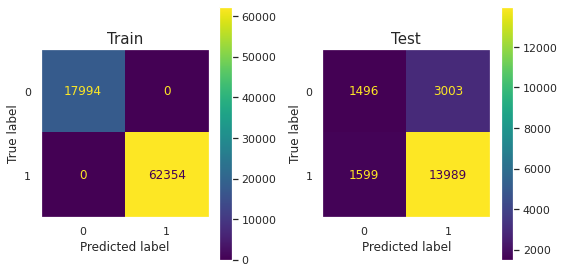

In [ ]:
#Code copied from Applied AI assignment

K=[x for x in range(1,11,2)]
cv_f1_score_array=[]
for i in tqdm(K, position=0, leave=True):
    knn = KNeighborsClassifier(weights='distance',n_jobs=-1,n_neighbors=i)
    knn.fit(X_train_final_truncated,y_train)
    sig_clf = CalibratedClassifierCV(knn)
    sig_clf.fit(X_train_final_truncated, y_train)
    predict_y = sig_clf.predict_proba(X_cv_final)
    cv_f1_score_array.append(f1_score(y_cv, (predict_y[:,1]>0.5).astype(int), labels=knn.classes_))

print('\n')
for i in range(len(cv_f1_score_array)):
    print ('F1 score for the value of K = ',K[i],'is',cv_f1_score_array[i])

best_n = np.argmax(cv_f1_score_array)
print('Best value of K is',K[best_n])   

knn_clf = KNeighborsClassifier(weights='distance',n_jobs=-1,n_neighbors=K[best_n])
knn_clf.fit(X_train_final_truncated, y_train)

print('\nTrain F1 score is',f1_score(y_train, knn_clf.predict(X_train_final_truncated),'macro'))
print('Test F1 score is',f1_score(y_test, knn_clf.predict(X_test_final_truncated),'macro'))

print("\nConfusion matrix: \n")
conf_plot(knn_clf,X_train_final_truncated,y_train,X_test_final_truncated,y_test) 

Using Logistic Regression to make the prediction.

100%|██████████| 10/10 [02:54<00:00, 17.40s/it]




F1 score for the value of alpha =  1e-07 is 0.8907907511956561
F1 score for the value of alpha =  1e-06 is 0.8977410024530443
F1 score for the value of alpha =  1e-05 is 0.9016700366958736
F1 score for the value of alpha =  0.0001 is 0.8953691649618746
F1 score for the value of alpha =  0.001 is 0.889903191371885
F1 score for the value of alpha =  0.01 is 0.8871316126670328
F1 score for the value of alpha =  0.1 is 0.8862999235446173
F1 score for the value of alpha =  1 is 0.8854818296872176
F1 score for the value of alpha =  10 is 0.8807989690721649
F1 score for the value of alpha =  100 is 0.8780418588151827
Best value of alpha is 1e-05

Train F1 score is 0.9004493002886735
Test F1 score is 0.9003996124969726

Confusion matrix: 



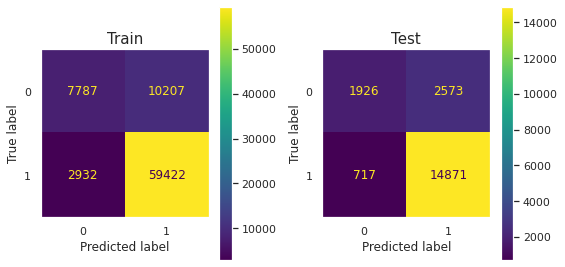

In [ ]:
alpha=[10 ** x for x in range(-7,3)]
cv_f1_score_array=[]
for i in tqdm(alpha, position=0, leave=True):
    log_reg = SGDClassifier(n_jobs=-1, loss='log', alpha=i)
    log_reg.fit(X_train_final_truncated,y_train)
    sig_clf = CalibratedClassifierCV(log_reg)
    sig_clf.fit(X_train_final_truncated, y_train)
    predict_y = sig_clf.predict_proba(X_cv_final)
    cv_f1_score_array.append(f1_score(y_cv, (predict_y[:,1]>0.5).astype(int), labels=log_reg.classes_))

print('\n')
for i in range(len(cv_f1_score_array)):
    print ('F1 score for the value of alpha = ',alpha[i],'is',cv_f1_score_array[i])

best_n = np.argmax(cv_f1_score_array)
print('Best value of alpha is',alpha[best_n])   

sgd = SGDClassifier(alpha=alpha[best_n], n_jobs=-1, loss='log')
sgd.fit(X_train_final_truncated, y_train)

print('\nTrain F1 score is',f1_score(y_train, sgd.predict(X_train_final_truncated),'macro'))
print('Test F1 score is',f1_score(y_test, sgd.predict(X_test_final_truncated),'macro'))

print("\nConfusion matrix: \n")
conf_plot(sgd,X_train_final_truncated,y_train,X_test_final_truncated,y_test) 

Using random forest to make the prediction.

100%|██████████| 6/6 [03:29<00:00, 34.89s/it]




F1 score for the number of estimators =  50 is 0.9554834222119175
F1 score for the number of estimators =  80 is 0.9553115818772229
F1 score for the number of estimators =  110 is 0.9553519656731997
F1 score for the number of estimators =  150 is 0.9555435286840884
F1 score for the number of estimators =  180 is 0.9556242752222651
F1 score for the number of estimators =  210 is 0.9556913083823074
Best value of the number of estimators is 210

Train F1 score is 0.9583433104439107
Test F1 score is 0.9161970329302098

Confusion matrix: 



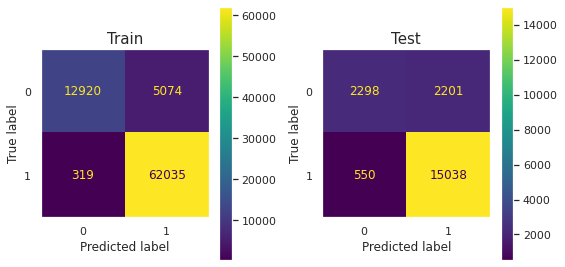

In [ ]:
#Code copied from Applied AI assignment

estimators=[50,80,110,150,180,210]
cv_f1_score_array=[]
for i in tqdm(estimators, position=0, leave=True):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1, max_depth=17)
    r_cfl.fit(X_train_final_truncated,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl)
    sig_clf.fit(X_train_final_truncated, y_train)
    predict_y = sig_clf.predict_proba(X_cv_final)
    cv_f1_score_array.append(f1_score(y_cv, (predict_y[:,1]>0.5).astype(int), labels=r_cfl.classes_))

print('\n')
for i in range(len(cv_f1_score_array)):
    print ('F1 score for the number of estimators = ',estimators[i],'is',cv_f1_score_array[i])

best_n = np.argmax(cv_f1_score_array)
print('Best value of the number of estimators is',estimators[best_n])   

rf = RandomForestClassifier(n_estimators=estimators[best_n], n_jobs=-1, max_depth=17)
rf.fit(X_train_final_truncated, y_train)

print('\nTrain F1 score is',f1_score(y_train, rf.predict(X_train_final_truncated),'macro'))
print('Test F1 score is',f1_score(y_test, rf.predict(X_test_final_truncated),'macro'))

print("\nConfusion matrix: \n")
conf_plot(rf,X_train_final_truncated,y_train,X_test_final_truncated,y_test) 

Using xgboost to make the prediction.

100%|██████████| 6/6 [1:07:13<00:00, 672.24s/it]




F1 score for the number of estimators =  50 is 0.9174283739150473
F1 score for the number of estimators =  80 is 0.9221837754709726
F1 score for the number of estimators =  110 is 0.9250307881773399
F1 score for the number of estimators =  150 is 0.9285686780392006
F1 score for the number of estimators =  180 is 0.9307609365372767
F1 score for the number of estimators =  210 is 0.9323985978968452
Best value of the number of estimators is 210

Train F1 score is 0.9343593689880724
Test F1 score is 0.919189131168154

Confusion matrix: 



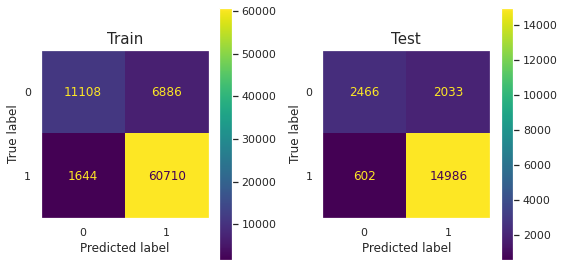

In [ ]:
#Code copied from Applied AI assignment

estimators=[50,80,110,150,180,210]
cv_f1_score_array=[]
for i in tqdm(estimators, position=0, leave=True):
    xgb_cfl = XGBClassifier(n_estimators=i,random_state=42,n_jobs=-1, max_depth=5)
    xgb_cfl.fit(X_train_final_truncated,y_train)
    sig_clf = CalibratedClassifierCV(xgb_cfl)
    sig_clf.fit(X_train_final_truncated, y_train)
    predict_y = sig_clf.predict_proba(X_cv_final)
    cv_f1_score_array.append(f1_score(y_cv, (predict_y[:,1]>0.5).astype(int), labels=xgb_cfl.classes_))

print('\n')
for i in range(len(cv_f1_score_array)):
    print ('F1 score for the number of estimators = ',estimators[i],'is',cv_f1_score_array[i])

best_n = np.argmax(cv_f1_score_array)
print('Best value of the number of estimators is',estimators[best_n])   

xgb = XGBClassifier(n_estimators=estimators[best_n], n_jobs=-1, max_depth=5)
xgb.fit(X_train_final_truncated, y_train)

print('\nTrain F1 score is',f1_score(y_train, xgb.predict(X_train_final_truncated)))
print('Test F1 score is',f1_score(y_test, xgb.predict(X_test_final_truncated)))

print("\nConfusion matrix: \n")
conf_plot(xgb,X_train_final_truncated,y_train,X_test_final_truncated,y_test) 

In [76]:
def conf_plot_deep(obj,X_train,y_train,X_test,y_test):
  fig, ax = plt.subplots(1,2, figsize=(8,4))
  cm1 = confusion_matrix(y_train,(obj.predict(X_train)>0.5).astype(int))
  cm2 = confusion_matrix(y_test,(obj.predict(X_test)>0.5).astype(int))
  sns.heatmap(cm1, annot=True, fmt='g', ax=ax[0])
  sns.heatmap(cm2, annot=True, fmt='g', ax=ax[1])
  ax[0].set_xlabel('Predicted label')
  ax[0].set_ylabel('True label')
  ax[1].set_xlabel('Predicted label')
  ax[1].set_ylabel('True label')
  ax[0].set_title('Train',fontsize=15)
  ax[1].set_title('Test',fontsize=15)
  plt.tight_layout()

We are now creating a regularized multi layered perceptron.

In [ ]:
input_n = Input(shape=X_train_final_truncated.shape[1])
dense_0 = Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(input_n)
dense_1 = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(dense_0)
batch_1 = BatchNormalization() (dense_1)
dense_2 = Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(batch_1)
drop_0 = Dropout(0.5)(dense_2)
batch_2 = BatchNormalization()(drop_0)
dense_3 = Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(batch_2)
output_n = Dense(1, activation='linear')(dense_3)
model_mlp = Model(inputs=input_n, outputs=output_n)
model_mlp.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 116)]             0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               59904     
_________________________________________________________________
dense_27 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 64)                256 

In [ ]:
opt = Adam(learning_rate=0.0001)
model_mlp.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score(num_classes=1,average='macro',threshold=0.5)])
mod_ch = ModelCheckpoint('/content/checkpoint2.hdf5',monitor='val_loss',save_best_only=True, verbose=1)
history = model_mlp.fit(X_train_final_truncated, y_train.values, epochs=20, batch_size=64, validation_data=(X_test_final_truncated, y_test.values), callbacks=[mod_ch])

Epoch 1/20
1256/1256 [==============================] - 9s 7ms/step - loss: 0.5392 - f1_score: 0.9027 - val_loss: 0.4863 - val_f1_score: 0.9084

Epoch 00001: val_loss improved from inf to 0.48628, saving model to /content/checkpoint2.hdf5
Epoch 2/20
1256/1256 [==============================] - 8s 6ms/step - loss: 0.5133 - f1_score: 0.9001 - val_loss: 0.4845 - val_f1_score: 0.9094

Epoch 00002: val_loss improved from 0.48628 to 0.48446, saving model to /content/checkpoint2.hdf5
Epoch 3/20
1256/1256 [==============================] - 8s 6ms/step - loss: 0.5314 - f1_score: 0.8985 - val_loss: 0.5313 - val_f1_score: 0.8984

Epoch 00003: val_loss did not improve from 0.48446
Epoch 4/20
1256/1256 [==============================] - 8s 7ms/step - loss: 0.5535 - f1_score: 0.8890 - val_loss: 0.5253 - val_f1_score: 0.8981

Epoch 00004: val_loss did not improve from 0.48446
Epoch 5/20
1256/1256 [==============================] - 8s 6ms/step - loss: 0.5539 - f1_score: 0.8905 - val_loss: 0.5256 - val

Train F1 score is  0.9074849768191741
Test F1 score is  0.9057834959524762

Confusion matrix: 



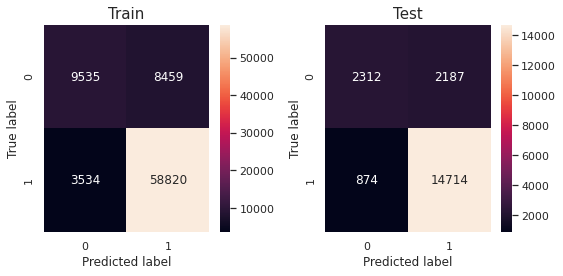

In [ ]:
print('Train F1 score is ',f1_score(y_train, (model_mlp.predict(X_train_final_truncated)>0.5).astype(int),'macro'))
print('Test F1 score is ',f1_score(y_test, (model_mlp.predict(X_test_final_truncated)>0.5).astype(int),'macro'))

print("\nConfusion matrix: \n")
conf_plot_deep(model_mlp,X_train_final_truncated,y_train,X_test_final_truncated,y_test)

Using K nearest neighbours and logistic regression, the count of the false positives was greater than the count of the true negatives on the test set. The other algorithms were able to properly classify the points in the test set.

<h1>Autoencoders</h1>

We shall now be using the output predicted by the autoencoder to make the predictions.

In [ ]:
X_train_final_new, X_cv_final, y_train_new, y_cv = train_test_split(X_train_encode, y_train, stratify=y_train, test_size=0.2, random_state=45)

Using weighted K-nearest neighbours to make the prediction.

100%|██████████| 5/5 [20:38<00:00, 247.77s/it]




F1 score for the value of K =  1 is 0.8739007042500263
F1 score for the value of K =  3 is 1.0
F1 score for the value of K =  5 is 1.0
F1 score for the value of K =  7 is 1.0
F1 score for the value of K =  9 is 1.0
Best value of K is 3

Train F1 score is 1.0
Test F1 score is 0.8564036222509702

Confusion matrix: 



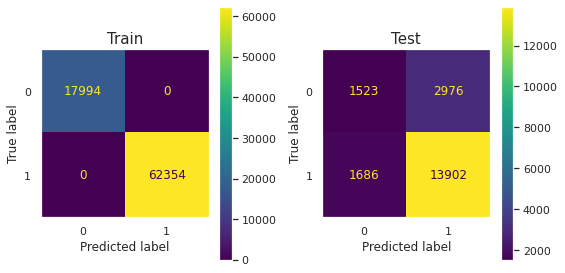

In [ ]:
#Code copied from Applied AI assignment

K=[x for x in range(1,11,2)]
cv_f1_score_array=[]
for i in tqdm(K, position=0, leave=True):
    knn = KNeighborsClassifier(weights='distance',n_jobs=-1,n_neighbors=i)
    knn.fit(X_train_encode,y_train)
    sig_clf = CalibratedClassifierCV(knn)
    sig_clf.fit(X_train_encode, y_train)
    predict_y = sig_clf.predict_proba(X_cv_final)
    cv_f1_score_array.append(f1_score(y_cv, (predict_y[:,1]>0.5).astype(int), labels=knn.classes_))

print('\n')
for i in range(len(cv_f1_score_array)):
    print ('F1 score for the value of K = ',K[i],'is',cv_f1_score_array[i])

best_n = np.argmax(cv_f1_score_array)
print('Best value of K is',K[best_n])   

knn_clf = KNeighborsClassifier(weights='distance',n_jobs=-1,n_neighbors=K[best_n])
knn_clf.fit(X_train_encode, y_train)

print('\nTrain F1 score is',f1_score(y_train, knn_clf.predict(X_train_encode),'macro'))
print('Test F1 score is',f1_score(y_test, knn_clf.predict(X_test_encode),'macro'))

print("\nConfusion matrix: \n")
conf_plot(knn_clf,X_train_encode,y_train,X_test_encode,y_test) 

Using Logistic Regression to make the prediction.

100%|██████████| 10/10 [05:42<00:00, 34.23s/it]




F1 score for the value of alpha =  1e-07 is 0.8856262980734799
F1 score for the value of alpha =  1e-06 is 0.8771484925331079
F1 score for the value of alpha =  1e-05 is 0.8843217012773853
F1 score for the value of alpha =  0.0001 is 0.888485552490199
F1 score for the value of alpha =  0.001 is 0.8893620145363776
F1 score for the value of alpha =  0.01 is 0.889665318131666
F1 score for the value of alpha =  0.1 is 0.887361728712653
F1 score for the value of alpha =  1 is 0.8830847580938522
F1 score for the value of alpha =  10 is 0.8739007042500263
F1 score for the value of alpha =  100 is 0.8739007042500263
Best value of alpha is 0.01

Train F1 score is 0.8886979763268423
Test F1 score is 0.8874160532566937

Confusion matrix: 



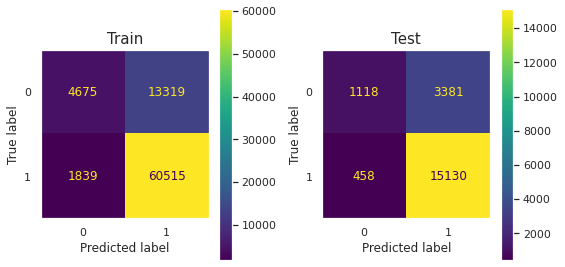

In [ ]:
#Code copied from Applied AI assignment

alpha=[10 ** x for x in range(-7,3)]
cv_f1_score_array=[]
for i in tqdm(alpha, position=0, leave=True):
    log_reg = SGDClassifier(n_jobs=-1, loss='log', alpha=i)
    log_reg.fit(X_train_encode,y_train)
    sig_clf = CalibratedClassifierCV(log_reg)
    sig_clf.fit(X_train_encode, y_train)
    predict_y = sig_clf.predict_proba(X_cv_final)
    cv_f1_score_array.append(f1_score(y_cv, (predict_y[:,1]>0.5).astype(int), labels=log_reg.classes_))

print('\n')
for i in range(len(cv_f1_score_array)):
    print ('F1 score for the value of alpha = ',alpha[i],'is',cv_f1_score_array[i])

best_n = np.argmax(cv_f1_score_array)
print('Best value of alpha is',alpha[best_n])   

sgd = SGDClassifier(alpha=alpha[best_n], n_jobs=-1, loss='log')
sgd.fit(X_train_encode, y_train)

print('\nTrain F1 score is',f1_score(y_train, sgd.predict(X_train_encode),'macro'))
print('Test F1 score is',f1_score(y_test, sgd.predict(X_test_encode),'macro'))

print("\nConfusion matrix: \n")
conf_plot(sgd,X_train_encode,y_train,X_test_encode,y_test) 

Using random forest to make the prediction.

100%|██████████| 6/6 [02:31<00:00, 25.27s/it]




F1 score for the number of estimators =  50 is 0.9421556387848523
F1 score for the number of estimators =  80 is 0.9441516587677725
F1 score for the number of estimators =  110 is 0.9445455924745866
F1 score for the number of estimators =  150 is 0.9449440333902486
F1 score for the number of estimators =  180 is 0.9452351132870318
F1 score for the number of estimators =  210 is 0.9450557790088792
Best value of the number of estimators is 180

Train F1 score is 0.9434442240426401
Test F1 score is 0.8895403377110694

Confusion matrix: 



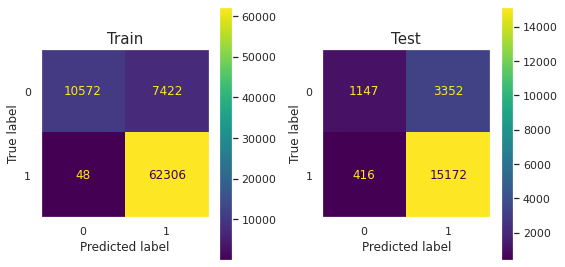

In [ ]:
#Code copied from Applied AI assignment

estimators=[50,80,110,150,180,210]
cv_f1_score_array=[]
for i in tqdm(estimators, position=0, leave=True):
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1, max_depth=17)
    r_cfl.fit(X_train_encode,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl)
    sig_clf.fit(X_train_encode, y_train)
    predict_y = sig_clf.predict_proba(X_cv_final)
    cv_f1_score_array.append(f1_score(y_cv, (predict_y[:,1]>0.5).astype(int), labels=r_cfl.classes_))

print('\n')
for i in range(len(cv_f1_score_array)):
    print ('F1 score for the number of estimators = ',estimators[i],'is',cv_f1_score_array[i])

best_n = np.argmax(cv_f1_score_array)
print('Best value of the number of estimators is',estimators[best_n])   

rf = RandomForestClassifier(n_estimators=estimators[best_n], n_jobs=-1, max_depth=17)
rf.fit(X_train_encode, y_train)

print('\nTrain F1 score is',f1_score(y_train, rf.predict(X_train_encode),'macro'))
print('Test F1 score is',f1_score(y_test, rf.predict(X_test_encode),'macro'))

print("\nConfusion matrix: \n")
conf_plot(rf,X_train_encode,y_train,X_test_encode,y_test) 

Using xgboost to make predictions.

100%|██████████| 6/6 [03:17<00:00, 32.84s/it]




F1 score for the number of estimators =  50 is 0.9087479723867367
F1 score for the number of estimators =  80 is 0.9111615588346577
F1 score for the number of estimators =  110 is 0.9137591019417476
F1 score for the number of estimators =  150 is 0.9165399817573731
F1 score for the number of estimators =  180 is 0.9183557059740655
F1 score for the number of estimators =  210 is 0.9199436598271727
Best value of the number of estimators is 210

Train F1 score is 0.9199814387974775
Test F1 score is 0.8687349379213568
Confusion matrix: 



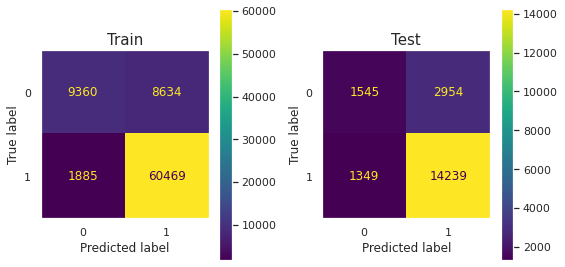

In [ ]:
#Code copied from Applied AI assignment

estimators=[50,80,110,150,180,210]
cv_f1_score_array=[]
for i in tqdm(estimators, position=0, leave=True):
    xg_cfl=XGBClassifier(n_estimators=i,random_state=42,n_jobs=-1, max_depth=5)
    xg_cfl.fit(X_train_encode,y_train)
    sig_clf = CalibratedClassifierCV(xg_cfl)
    sig_clf.fit(X_train_encode, y_train)
    predict_y = sig_clf.predict_proba(X_cv_final)
    cv_f1_score_array.append(f1_score(y_cv, (predict_y[:,1]>0.5).astype(int), labels=xg_cfl.classes_))

print('\n')
for i in range(len(cv_f1_score_array)):
    print ('F1 score for the number of estimators = ',estimators[i],'is',cv_f1_score_array[i])

best_n = np.argmax(cv_f1_score_array)
print('Best value of the number of estimators is',estimators[best_n])   

xgb = XGBClassifier(n_estimators=estimators[best_n], n_jobs=-1, max_depth=5)
xgb.fit(X_train_encode, y_train)

print('\nTrain F1 score is',f1_score(y_train, xgb.predict(X_train_encode)))
print('Test F1 score is',f1_score(y_test, xgb.predict(X_test_encode)))

print("\nConfusion matrix: \n")
conf_plot(xgb,X_train_encode,y_train,X_test_encode,y_test) 

We are now creating a regularized multi layered perceptron.

In [ ]:
input_n = Input(shape=X_train_encode.shape[1])
dense_0 = Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(input_n)
dense_1 = Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(dense_0)
batch_1 = BatchNormalization() (dense_1)
dense_2 = Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(batch_1)
drop_0 = Dropout(0.5)(dense_2)
batch_2 = BatchNormalization()(drop_0)
dense_3 = Dense(32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(batch_2)
output_n = Dense(1, activation='linear')(dense_3)
model_mlp2 = Model(inputs=input_n, outputs=output_n)
model_mlp2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 116)]             0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               59904     
_________________________________________________________________
dense_32 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 64)                256 

In [ ]:
opt = Adam(learning_rate=0.001)
model_mlp2.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score(num_classes=1,average='macro',threshold=0.5)])
mod_ch = ModelCheckpoint('/content/checkpoint3.hdf5',monitor='val_loss',save_best_only=True, verbose=1)
history = model_mlp2.fit(X_train_encode, y_train.values, epochs=20, batch_size=64, validation_data=(X_test_encode, y_test.values), callbacks=[mod_ch])

Epoch 1/20
1256/1256 [==============================] - 10s 7ms/step - loss: 0.4417 - f1_score: 0.8900 - val_loss: 0.4418 - val_f1_score: 0.8926

Epoch 00001: val_loss improved from inf to 0.44185, saving model to /content/checkpoint3.hdf5
Epoch 2/20
1256/1256 [==============================] - 8s 7ms/step - loss: 0.4387 - f1_score: 0.8916 - val_loss: 0.4399 - val_f1_score: 0.8936

Epoch 00002: val_loss improved from 0.44185 to 0.43993, saving model to /content/checkpoint3.hdf5
Epoch 3/20
1256/1256 [==============================] - 8s 7ms/step - loss: 0.4358 - f1_score: 0.8928 - val_loss: 0.4474 - val_f1_score: 0.8917

Epoch 00003: val_loss did not improve from 0.43993
Epoch 4/20
1256/1256 [==============================] - 8s 6ms/step - loss: 0.4503 - f1_score: 0.8909 - val_loss: 0.4391 - val_f1_score: 0.8930

Epoch 00004: val_loss improved from 0.43993 to 0.43912, saving model to /content/checkpoint3.hdf5
Epoch 5/20
1256/1256 [==============================] - 8s 7ms/step - loss: 0.

Train F1 score is  0.8940592943298388
Test F1 score is  0.8924489244892448

Confusion matrix: 



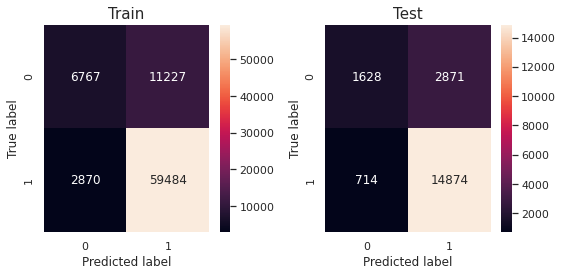

In [ ]:
print('Train F1 score is ',f1_score(y_train, (model_mlp2.predict(X_train_encode)>0.5).astype(int),'macro'))
print('Test F1 score is ',f1_score(y_test, (model_mlp2.predict(X_test_encode)>0.5).astype(int),'macro'))

print("\nConfusion matrix: \n")
conf_plot_deep(model_mlp2,X_train_encode,y_train,X_test_encode,y_test)

None of the algorithms were able to properly classify the test set properly.

<h1>Original dataset</h1>

In [60]:
tok = Tokenizer()
tok.fit_on_texts(X_train_comment_preprocess)
X_train_text_input = pad_sequences(tok.texts_to_sequences(X_train_comment_preprocess), padding='post')
X_test_text_input = pad_sequences(tok.texts_to_sequences(X_test_comment_preprocess), padding='post')

In [ ]:
text_input = Input(shape=(X_train_text_input.shape[1]))
embedding_layer = Embedding(len(ft.words),300,weights=[embedding_matrix],input_length=X_train_text_input.shape[1],trainable=False)(text_input)
lstm_1 = LSTM(64,return_sequences=True)(embedding_layer)
flat_1 = Flatten()(lstm_1)

other_input = Input(shape=(X_train_final[:,:-300].shape[1]))
dense_1 = Dense(128, activation='relu', kernel_initializer='he_normal')(other_input)
batch_1 = BatchNormalization()(dense_1)
dense_2 = Dense(64, activation='relu', kernel_initializer='he_normal')(batch_1)
batch_2 = BatchNormalization()(dense_2)

concat = Concatenate()([batch_2,flat_1])
dense_3 = Dense(64, activation='relu', kernel_initializer='he_normal')(concat)
batch_3 = BatchNormalization()(dense_3)
dense_4 = Dense(32, activation='relu', kernel_initializer='he_normal')(batch_3)
output_ = Dense(1, activation='sigmoid')(dense_4)

model_rnn = Model(inputs=[text_input,other_input], outputs=output_)
model_rnn.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 128)          4224        input_10[0][0]                   
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128)          512         dense_36[0][0]                   
____________________________________________________________________________________________

In [ ]:
opt = Adam(learning_rate=0.001)
model_rnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score(num_classes=1,average='macro',threshold=0.5)])
mod_ch = ModelCheckpoint('/content/checkpoint4.hdf5',monitor='val_loss',save_best_only=True, verbose=1)
history = model_rnn.fit([X_train_text_input,X_train_final[:,:-300]], y_train.values, epochs=20, batch_size=64, validation_data=([X_test_text_input,X_test_final[:,:-300]], y_test.values), callbacks=[mod_ch])

Epoch 1/20
1256/1256 [==============================] - 92s 71ms/step - loss: 0.4021 - f1_score: 0.9009 - val_loss: 0.5702 - val_f1_score: 0.8283

Epoch 00001: val_loss improved from inf to 0.57022, saving model to /content/checkpoint4.hdf5
Epoch 2/20
1256/1256 [==============================] - 87s 70ms/step - loss: 0.3588 - f1_score: 0.9164 - val_loss: 0.3989 - val_f1_score: 0.9081

Epoch 00002: val_loss improved from 0.57022 to 0.39892, saving model to /content/checkpoint4.hdf5
Epoch 3/20
1256/1256 [==============================] - 89s 71ms/step - loss: 0.3482 - f1_score: 0.9199 - val_loss: 0.3526 - val_f1_score: 0.9213

Epoch 00003: val_loss improved from 0.39892 to 0.35264, saving model to /content/checkpoint4.hdf5
Epoch 4/20
1256/1256 [==============================] - 90s 71ms/step - loss: 0.3387 - f1_score: 0.9225 - val_loss: 0.3509 - val_f1_score: 0.9192

Epoch 00004: val_loss improved from 0.35264 to 0.35085, saving model to /content/checkpoint4.hdf5
Epoch 5/20
1256/1256 [==

Train F1 score is  0.9498261530313845
Test F1 score is  0.9211091344089319

Confusion matrix: 



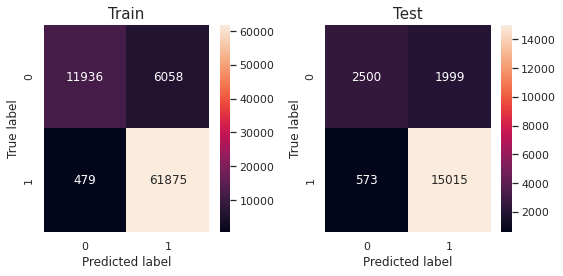

In [ ]:
print('Train F1 score is ',f1_score(y_train, (model_rnn.predict([X_train_text_input,X_train_final[:,:-300]])>0.5).astype(int),'macro'))
print('Test F1 score is ',f1_score(y_test, (model_rnn.predict([X_test_text_input,X_test_final[:,:-300]])>0.5).astype(int),'macro'))

print("\nConfusion matrix: \n")
conf_plot_deep(model_rnn,[X_train_text_input,X_train_final[:,:-300]],y_train,[X_test_text_input,X_test_final[:,:-300]],y_test)

In [72]:
text_input = Input(shape=(X_train_text_input.shape[1]))
reshape = Reshape((-1,1))(text_input)
conv1_1 = Conv1D(filters=256,kernel_size=8,strides=1,activation='relu',padding='same')(reshape)
lstm_1 = LSTM(128,return_sequences=True)(conv1_1)
conv1_2 = Conv1D(filters=128,kernel_size=8,strides=1,activation='relu',padding='same')(lstm_1)
lstm_2 = LSTM(64,return_sequences=True)(conv1_2)
flat_1 = Flatten()(lstm_2)

other_input = Input(shape=(X_train_final[:,:-300].shape[1]))
dense_1 = Dense(128, activation='relu', kernel_initializer='he_normal')(other_input)
batch_1 = BatchNormalization()(dense_1)
dense_2 = Dense(64, activation='relu', kernel_initializer='he_normal')(batch_1)
batch_2 = BatchNormalization()(dense_2)

concat = Concatenate()([batch_2,flat_1])
dense_3 = Dense(64, activation='relu', kernel_initializer='he_normal')(concat)
batch_3 = BatchNormalization()(dense_3)
dense_4 = Dense(32, activation='relu', kernel_initializer='he_normal')(batch_3)
output_ = Dense(1, activation='sigmoid')(dense_4)

model_cnn_rnn = Model(inputs=[text_input,other_input], outputs=output_)
model_cnn_rnn.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 38)]         0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 38, 1)        0           input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 38, 256)      2304        reshape_5[0][0]                  
____________________________________________________________________________________________

In [73]:
opt = Adam(learning_rate=0.001)
model_cnn_rnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=[F1Score(num_classes=1,average='macro',threshold=0.5)])
mod_ch = ModelCheckpoint('/content/checkpoint4.hdf5',monitor='val_loss',save_best_only=True, verbose=1)
history = model_cnn_rnn.fit([X_train_text_input,X_train_final[:,:-300]], y_train.values, epochs=20, batch_size=64, validation_data=([X_test_text_input,X_test_final[:,:-300]], y_test.values), callbacks=[mod_ch])

Epoch 1/20
1256/1256 [==============================] - 201s 156ms/step - loss: 0.4409 - f1_score: 0.8894 - val_loss: 0.4231 - val_f1_score: 0.8986

Epoch 00001: val_loss improved from inf to 0.42309, saving model to /content/checkpoint4.hdf5
Epoch 2/20
1256/1256 [==============================] - 206s 164ms/step - loss: 0.4183 - f1_score: 0.8955 - val_loss: 0.4184 - val_f1_score: 0.8948

Epoch 00002: val_loss improved from 0.42309 to 0.41842, saving model to /content/checkpoint4.hdf5
Epoch 3/20
1256/1256 [==============================] - 203s 161ms/step - loss: 0.4107 - f1_score: 0.8981 - val_loss: 0.4220 - val_f1_score: 0.8919

Epoch 00003: val_loss did not improve from 0.41842
Epoch 4/20
1256/1256 [==============================] - 195s 155ms/step - loss: 0.4042 - f1_score: 0.9008 - val_loss: 0.4086 - val_f1_score: 0.9017

Epoch 00004: val_loss improved from 0.41842 to 0.40864, saving model to /content/checkpoint4.hdf5
Epoch 5/20
1256/1256 [==============================] - 194s 15

Train F1 score is  0.9102997729694667
Test F1 score is  0.901090797357505

Confusion matrix: 



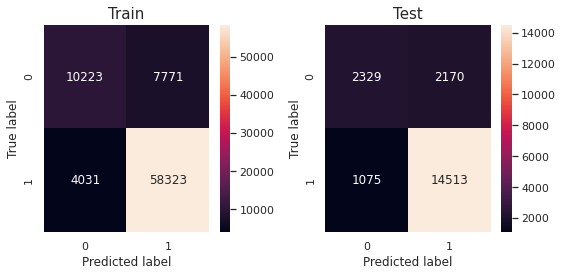

In [75]:
print('Train F1 score is ',f1_score(y_train, (model_cnn_rnn.predict([X_train_text_input,X_train_final[:,:-300]])>0.5).astype(int),'macro'))
print('Test F1 score is ',f1_score(y_test, (model_cnn_rnn.predict([X_test_text_input,X_test_final[:,:-300]])>0.5).astype(int),'macro'))

print("\nConfusion matrix: \n")
conf_plot_deep(model_cnn_rnn,[X_train_text_input,X_train_final[:,:-300]],y_train,[X_test_text_input,X_test_final[:,:-300]],y_test)

By comparing the results, we can say that dataset reduced using optimal hard threshold SVD performs slightly better than the dataset reduced using autoencoders. 

In [12]:
print('\nWithout Dimensionality reduction\n')

table1 = PrettyTable()
table1.field_names = ['Algorithm','Train macro F1 score', 'Test macro F1 score']
table1.add_row(['K nearest neighbour',1.0,0.8587])
table1.add_row(['Logistic regression',0.9004,0.9003])
table1.add_row(['Random forest',0.9583,0.9161])
table1.add_row(['XG Boost',0.9343,0.9191])
table1.add_row(['Multi layered perceptron',0.9074,0.9057])


print(table1.get_string(title='Hard threshold SVD'))
print('\n')

table2 = PrettyTable()
table2.field_names = ['Algorithm','Train macro F1 score', 'Test macro F1 score']
table2.add_row(['K nearest neighbour',1.0,0.8564])
table2.add_row(['Logistic regression',0.8886,0.8874])
table2.add_row(['Random forest',0.9434,0.8895])
table2.add_row(['XG Boost',0.9343,0.8867])
table2.add_row(['Multi layered perceptron',0.8940,0.8924])

print(table2.get_string(title='Autoencoders'))
print('\n')

print('Without Dimensionality reduction\n')
table3 = PrettyTable()
table3.field_names = ['Algorithm','Train macro F1 score', 'Test macro F1 score']
table3.add_row(['Dual input LSTM',0.9498,0.9211])
table3.add_row(['Dual input 1D-CNN and LSTM',0.9102,0.9011])

print(table3.get_string(title='Original dataset'))


Without Dimensionality reduction

+-----------------------------------------------------------------------+
|                           Hard threshold SVD                          |
+--------------------------+----------------------+---------------------+
|        Algorithm         | Train macro F1 score | Test macro F1 score |
+--------------------------+----------------------+---------------------+
|   K nearest neighbour    |         1.0          |        0.8587       |
|   Logistic regression    |        0.9004        |        0.9003       |
|      Random forest       |        0.9583        |        0.9161       |
|         XG Boost         |        0.9343        |        0.9191       |
| Multi layered perceptron |        0.9074        |        0.9057       |
+--------------------------+----------------------+---------------------+


+-----------------------------------------------------------------------+
|                              Autoencoders                             |
+

<h1>Conclusion</h1>

When we check the test macro F1 scores of the newly transformed matrices, we notice that the performance of the matrix obtained using hard threshold SVD is better than the performance of the matrix derived using Autoencoders. 
On comparing the confusion matrices of all the models, we see that the count of the false positives was greater than the count of the true negatives for all the models trained using reduced dimensionality matrix obtained using Autoencoders. For the last two models, we did not use the dimensionality reduced matrices as the input and instead used the matrix which we had created during the feature engineering phase as the input. Dual input LSTM is the best performing model.

In [ ]:
https://www.appliedaicourse.com/
https://www.kaggle.com/olistbr/brazilian-ecommerce    
http://www.pyrunner.com/weblog/2016/08/01/optimal-svht/
https://machinelearningmastery.com/autoencoder-for-classification/
https://stackoverflow.com/a/64477588
https://stackoverflow.com/a/7125157    
https://stackoverflow.com/a/47218282
https://stackoverflow.com/a/52057778
https://stackoverflow.com/a/11332580
https://stackoverflow.com/a/9532388    
   